In [ ]:
s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"


In [ ]:
!rm -rf temp
!mkdir temp
!aws s3 cp s3://aegovan-data/results/model_190317_0222 temp --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

In [31]:
!ls  temp

classes.json
feature_lens.json
predicted_test_unique_pub_v3_lessnegatve.json
predicted_val_unique_pub_v3_lessnegatve.json
run.log
training_scores_epoch_Objectdump_20190317_023424_0b316c7a-1a95-4107-aefa-6d937663ce50.json
validation_scores_epoch_Objectdump_20190317_023424_cc347127-c67a-4484-9e38-9d5d8ba2c3ae.json


In [4]:
!head -1 temp/run.log 

commit de0554d0bcba054165541f3f1384d2e6cb21f406


In [9]:
!head -10 temp/run.log | tail -8

Date:   Sun Mar 17 13:14:57 2019 +1100

    decrease network 50, 50
{'network': 'Linear', 'trainjson': '/data/train_unique_pub_v3_lessnegatve.json', 'valjson': '/data/val_unique_pub_v3_lessnegatve.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_190317_0222', 'epochs': 50, 'interaction_type': None, 'log_level': 'INFO'}
2019-03-17 02:22:40,788 - __main__ - INFO - Running with interaction type None, network Linear
2019-03-17 02:22:41,012 - __main__ - INFO - Training shape (4569, 4), test shape (742, 4)
2019-03-17 02:22:41,012 - __main__ - INFO - The embedding header is 5443656 200



In [10]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [11]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [12]:
results_file = "./temp/predicted_val_unique_pub_v3_lessnegatve.json"
validation_fit_file = "./temp/validation_scores_epoch_Objectdump_20190317_023424_cc347127-c67a-4484-9e38-9d5d8ba2c3ae.json"
train_fit_file = "./temp/training_scores_epoch_Objectdump_20190317_023424_0b316c7a-1a95-4107-aefa-6d937663ce50.json"


pos_label = True

In [13]:
#download_single_file(s3_data, results_file)

In [14]:
import pandas as pd

In [15]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [16]:
df_results.head(n=3)


,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,predicted,confidence_scores,actual
0,1,False,2662762_e7cabc4d-e871-4ece-99f4-7a50ddbe7b4e_fake_annot,deubiquitination,False,True,"[[o96013-1], [Serine/threonine-protein kinase PAK 4], [PAK4], [KIAA1142], [p21-activated kinase 4]]",O96013-1,"[[raf1_rat], [RAF proto-oncogene serine/threonine-protein kinase], [Raf1], [Raf], [Proto-oncogene c-RAF], [Raf-1]]",P11345,2,20637424,Why an A-loop phospho-mimetic fails to activate PAK1: understanding an inaccessible kinase state by molecular dynamics simulations.,"Crystal structures of inactive PAK1(K299R) and the activation (A)-loop phospho-mimetic PAK1(T423E) have suggested that the kinase domain is in an active state regardless of activation loop status. Contrary to a large body of literature, we find that neither is PAK1(T423E) active in cells, nor does it exhibit significant activity in vitro. To explain these discrepancies all-atom molecular dynamics (MD) simulations of PAK1(phospho-T423) in complex with ATP and substrate were performed. These simulations point to a key interaction between PAK1 Lys308, at the end of the alphaC helix, and the pThr423 phosphate group, not seen in X-ray structures. The orthologous PAK4 Arg359 fulfills the same role in immobilizing the alphaC helix. These in silico predictions were validated by experimental mutagenesis of PAK1 and PAK4. The simulations explain why the PAK1 A-loop phospho-mimetic is inactive, but also point to a key functional interaction likely found in other protein kinases.","Crystal structures of inactive A0A024R5P0(K299R) and the activation (A)-loop phospho-mimetic A0A024R5P0(T423E) have suggested that the kinase domain is in an active state regardless of activation loop status. Contrary to a large body of literature, we find that neither is A0A024R5P0(T423E) active in cells, nor does it exhibit significant activity in vitro. To explain these discrepancies all-atom molecular dynamics (MD) simulations of A0A024R5P0(phospho-T423) in complex with ATP and substrate were performed. These simulations point to a key interaction between A0A024R5P0 Lys308, at the end of the alphaC helix, and the pThr423 phosphate group, not seen in X-ray structures. The orthologous A0A024R0L8 Arg359 fulfills the same role in immobilizing the alphaC helix. These in silico predictions were validated by experimental mutagenesis of A0A024R5P0 and A0A024R0L8. The simulations explain why the A0A024R5P0 A-loop phospho-mimetic is inactive, but also point to a key functional interaction likely found in other protein kinases.",False,"{'False': -0.5180530548, 'True': -0.9055465460000001}",False
1,5,True,1404131_c14a757a-b371-4f9a-b3f6-4b90a9bc247d_fake_annot,ubiquitination,False,True,"[[ikka_human], [Inhibitor of nuclear factor kappa-B kinase subunit alpha], [CHUK], [IKKA], [TCF16], [I-kappa-B kinase 1], [Conserved helix-loop-helix ubiquitous kinase], [Nuclear factor NF-kappa-B inhibitor kinase alpha], [Transcription factor 16]]",Q5W0I4,"[[ikba_human], [NF-kappa-B inhibitor alpha], [NFKBIA], [IKBA], [MAD3], [NFKBI], [I-kappa-B-alpha], [Major histocompatibility complex enhancer-binding protein MAD3]]",B2R8L6,2,18922877,None,"The central role of plasmacytoid dendritic cells (pDC) in activating host immune responses stems from their high capacity to express alpha interferon (IFN-alpha) after stimulation of Toll-like receptors 7 and 9 (TLR7 and -9). This involves the adapter MyD88 and the kinases interleukin-1 receptor-associated kinase 1 (IRAK1), IRAK4, and IkappaB kinase alpha (IKKalpha), which activates IFN regulatory factor 7 (IRF7) and is independent of the canonical kinases TBK1 and IKKepsilon. We have recently shown that the immunosuppressive measles virus (MV) abolishes TLR7/9/MyD88-dependent IFN induction in human pDC (Schlender et al.

## Analyse Results

In [17]:
df = df_results

In [18]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=100)

,true,false,actual,predicted,confidence_scores
665,0.496483,0.503517,True,False,"{'False': -0.6861373186, 'True': -0.7002065182}"
72,0.481109,0.518891,False,False,"{'False': -0.6560615301, 'True': -0.7316612005}"
718,0.462773,0.537227,True,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
453,0.462773,0.537227,False,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
454,0.462773,0.537227,False,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
456,0.462773,0.537227,False,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
458,0.462773,0.537227,False,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
451,0.462773,0.537227,False,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
459,0.462773,0.537227,False,False,"{'False': -0.6213347912, 'True': -0.7705183029}"
717,0.462773,0.537227,True,False,"{'False': -0.6213347912, 'True': -0.7705183029}"


In [19]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"], average='macro')  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))

The F1 score is 0.422568093385214 and the accuracy is 0.7318059299191375


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

<Figure size 640x480 with 2 Axes>

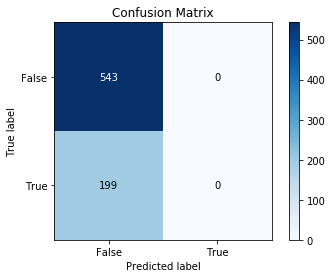

In [22]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

deubiquitination
ubiquitination
methylation


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


phosphorylation
acetylation
demethylation
dephosphorylation


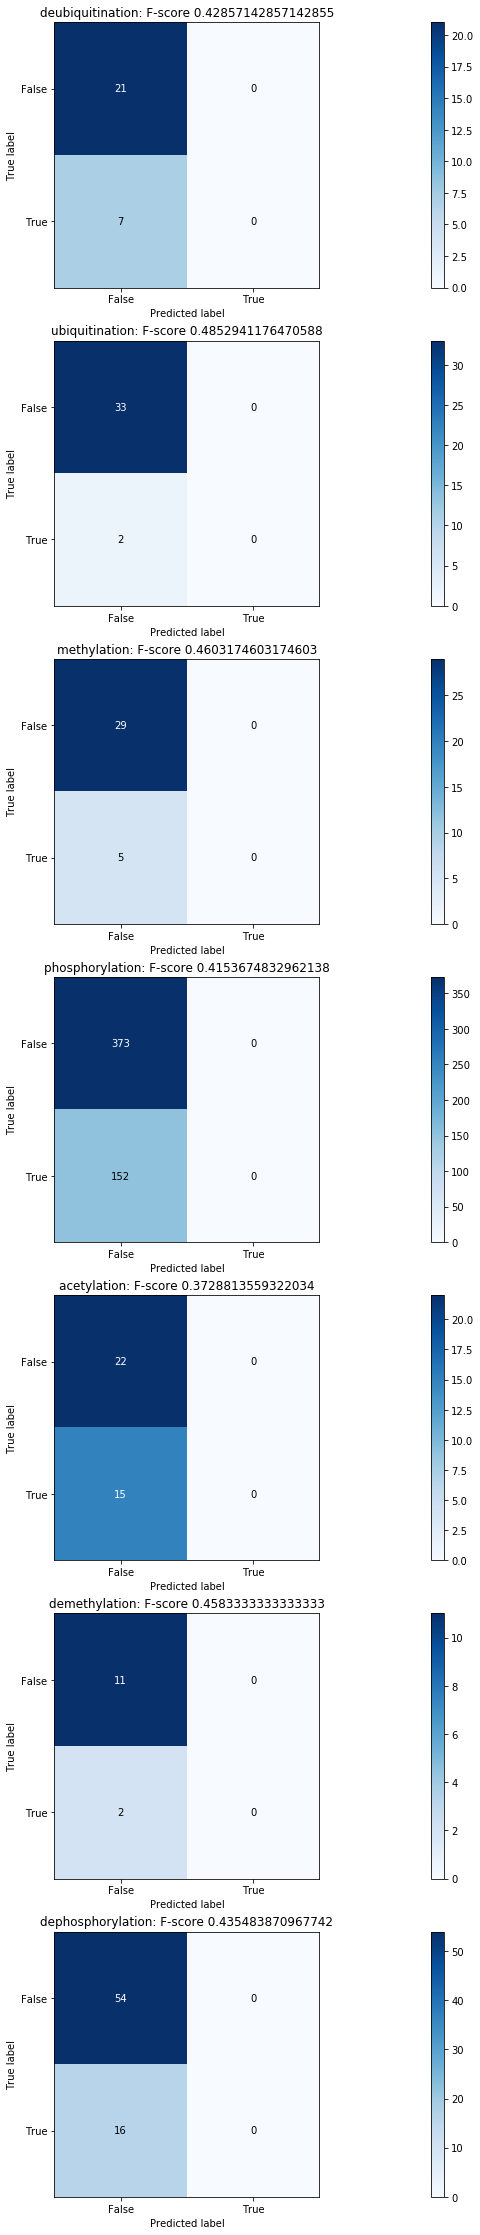

In [23]:
interactions = df["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
plt.show()
    
    


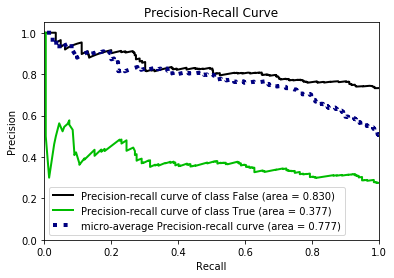

In [26]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

## Training / Test epoch fit

In [27]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [28]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit.sort_values(["score.f-score"], ascending=False).head(n=10)

,epoch,score.accuracy,score.f-score,score.precision,score.recall
49,49,0.919457,0.851012,0.860770,0.841473
46,46,0.918363,0.850261,0.852657,0.847878
48,48,0.915518,0.842577,0.858687,0.827062
47,47,0.915299,0.842363,0.857380,0.827862
43,43,0.913767,0.841385,0.846154,0.836669
45,45,0.910921,0.834351,0.848510,0.820657
41,41,0.908514,0.830632,0.840853,0.820657
40,40,0.908295,0.828910,0.845833,0.812650
39,39,0.910703,0.826972,0.879170,0.780624
44,44,0.906325,0.826440,0.837305,0.815853


In [29]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit.sort_values(["score.f-score"], ascending=False).head(n=10)

,epoch,score.accuracy,score.f-score,score.precision,score.recall
41,41,0.644205,0.561462,0.419355,0.849246
18,18,0.636119,0.557377,0.413625,0.854271
16,16,0.628032,0.550489,0.407229,0.849246
10,10,0.642857,0.547009,0.414508,0.804020
7,7,0.640162,0.545145,0.412371,0.804020
40,40,0.614555,0.543131,0.398126,0.854271
8,8,0.650943,0.541593,0.418033,0.768844
9,9,0.611860,0.541401,0.396270,0.854271
43,43,0.602426,0.535433,0.389908,0.854271
12,12,0.601078,0.533123,0.388506,0.849246


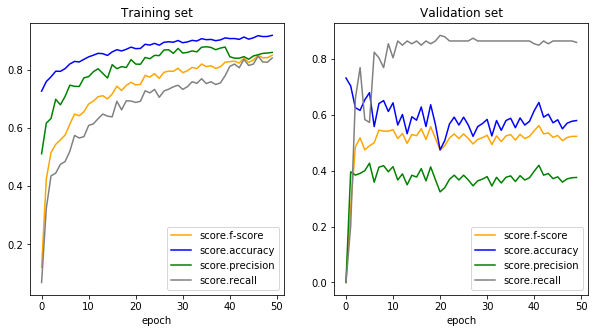

In [30]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score.f-score", ax = ax[0], color="orange")
df_train_fit.plot.line(x="epoch", y="score.accuracy", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score.precision", ax = ax[0], color ="green")
df_train_fit.plot.line(x="epoch", y="score.recall", ax = ax[0], color ="gray")
ax[0].set_title("Training set")


df_val_fit.plot.line(x="epoch", y="score.f-score", ax = ax[1], color ="orange")
df_val_fit.plot.line(x="epoch", y="score.accuracy", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score.precision", ax = ax[1], color ="green")
df_val_fit.plot.line(x="epoch", y="score.recall", ax = ax[1], color ="gray")
ax[1].set_title("Validation set")


plt.show()